# Analysis of multivariate random variables

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, optimize
import seaborn as sns
from math import sqrt
from itertools import combinations
sns.set_theme(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lars, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# https://drive.google.com/file/d/1HLg3JNYgewoigLfXsKk6Cs33TBZB4dl-/view?usp=sharing
id = '1HLg3JNYgewoigLfXsKk6Cs33TBZB4dl-' 
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('smart_home.csv')  

In [5]:
smart_home = pd.read_csv('smart_home.csv')
print(smart_home.shape)
smart_home.dropna(inplace=True)
print(smart_home.shape)
smart_home['time'] = smart_home['time'].apply(lambda x: pd.Timestamp(int(x), unit='s'))
smart_home['second'] = smart_home['time'].apply(lambda x: x.second)
smart_home['hour'] = smart_home['time'].apply(lambda x: x.hour)
smart_home = smart_home[smart_home['second'] == 0]
smart_home.drop('second', axis=1, inplace=True)
smart_home.reset_index(inplace=True, drop=True)
print(smart_home.shape)
smart_home.head(5)

(503911, 32)
(503910, 32)
(8399, 33)


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,hour
0,2016-01-01 05:00:00,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,0.000150,0.000000,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.40,0.0,5
1,2016-01-01 05:01:00,0.465133,0.003450,0.465133,0.000017,0.064500,0.062633,0.043250,0.005017,0.123350,0.012950,0.000717,0.000083,0.000017,0.031800,0.001000,0.004233,0.001633,0.003450,35.87,partly-cloudy-night,0.61,10.0,Mostly Cloudy,29.40,1016.25,8.29,0.75,285.0,0.0,23.90,0.0,5
2,2016-01-01 05:02:00,0.539167,0.003517,0.539167,0.000033,0.100133,0.116283,0.043367,0.007617,0.007083,0.013133,0.000683,0.000050,0.000000,0.031800,0.001017,0.004083,0.001617,0.003517,35.40,clear-night,0.61,10.0,Clear,28.87,1015.98,8.20,0.75,281.0,0.0,23.39,0.0,5
3,2016-01-01 05:03:00,0.380317,0.003433,0.380317,0.000000,0.070233,0.062700,0.070417,0.005100,0.007167,0.013150,0.000733,0.000033,0.000033,0.031783,0.001017,0.004267,0.001650,0.003433,35.25,clear-night,0.64,10.0,Clear,30.51,1016.07,5.47,0.75,265.0,0.0,24.18,0.0,5
4,2016-01-01 05:04:00,0.940617,0.003500,0.940617,0.000200,0.430700,0.063417,0.043533,0.122917,0.006983,0.012750,0.000483,0.000217,0.000000,0.031733,0.001000,0.004117,0.001567,0.003500,35.49,clear-night,0.64,10.0,Clear,29.65,1015.86,7.08,0.75,265.0,0.0,24.35,0.0,5


In [42]:
smart_home.summary.unique()

array(['Clear', 'Mostly Cloudy', 'Overcast', 'Partly Cloudy', 'Drizzle',
       'Light Rain', 'Rain', 'Light Snow', 'Flurries', 'Breezy', 'Snow',
       'Rain and Breezy', 'Foggy', 'Breezy and Mostly Cloudy',
       'Breezy and Partly Cloudy', 'Flurries and Breezy', 'Dry',
       'Heavy Snow'], dtype=object)

In [6]:
def outlier_removal(df, var):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    
    min_dist = q1 - (1.5 * (q3 - q1))
    max_dist = q3 + (1.5 * (q3 - q1))

    df_list = list(df[(df[var] < max_dist) & (df[var] > min_dist)][var].values)
    df = pd.DataFrame(df_list)
    df.rename({0: var}, axis=1, inplace=True)
    return df[var]

In [7]:
subsample = ['windSpeed', 'pressure', 'temperature', 'humidity', 'apparentTemperature']
target = ['gen [kW]']
subsample_target = subsample + target
smart_home_subsample = smart_home[subsample_target]
smart_home_subsample

,windSpeed,pressure,temperature,humidity,apparentTemperature,gen [kW]
0,9.18,1016.91,36.14,0.62,29.26,0.003483
1,8.29,1016.25,35.87,0.61,29.40,0.003450
2,8.20,1015.98,35.40,0.61,28.87,0.003517
3,5.47,1016.07,35.25,0.64,30.51,0.003433
4,7.08,1015.86,35.49,0.64,29.65,0.003500
...,...,...,...,...,...,...
8394,10.97,1012.77,36.63,0.72,29.03,0.004133
8395,11.77,1012.79,37.98,0.69,30.39,0.004133
8396,12.40,1012.28,36.73,0.79,28.57,0.004117
8397,7.82,1011.87,35.91,0.82,29.71,0.004117


### Step 1
You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function for MRV (or probability law in case of discrete MRV).

form of histogram

In [8]:
def estimation(df, var, ax):  
    df = outlier_removal(df, var)
    x = np.linspace(df.min(), df.max(), len(df))
    kernel = stats.kde.gaussian_kde(df)
    sns.histplot(df, kde=False, stat='density', ax=ax)
    ax.plot(x, kernel(x), 'r-')
    ax.set_ylabel("Density")
    ax.set_xlabel(var)

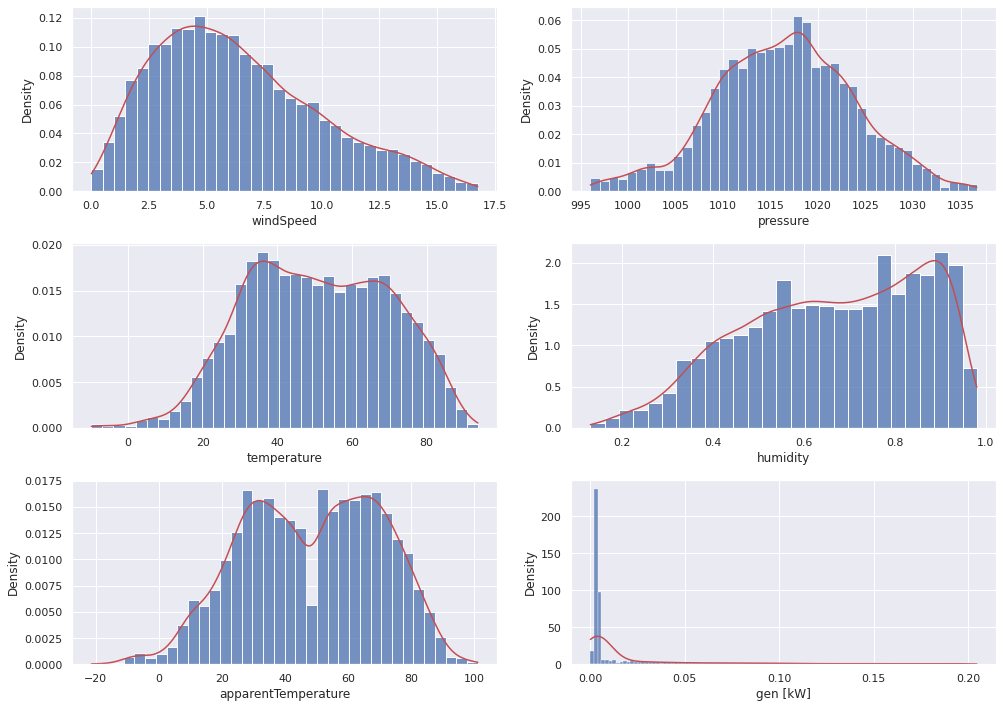

In [180]:
axs = {key: 0 for key in subsample_target}
fig, ((axs[subsample_target[0]], axs[subsample_target[1]]),
      (axs[subsample_target[2]], axs[subsample_target[3]]),
      (axs[subsample_target[4]], axs[subsample_target[5]])
      ) = plt.subplots(3, 2)
fig.set_size_inches(14, 10)

for var in subsample_target:
    estimation(smart_home_subsample, var, axs[var])

fig.tight_layout()

using kernel density function for MRV

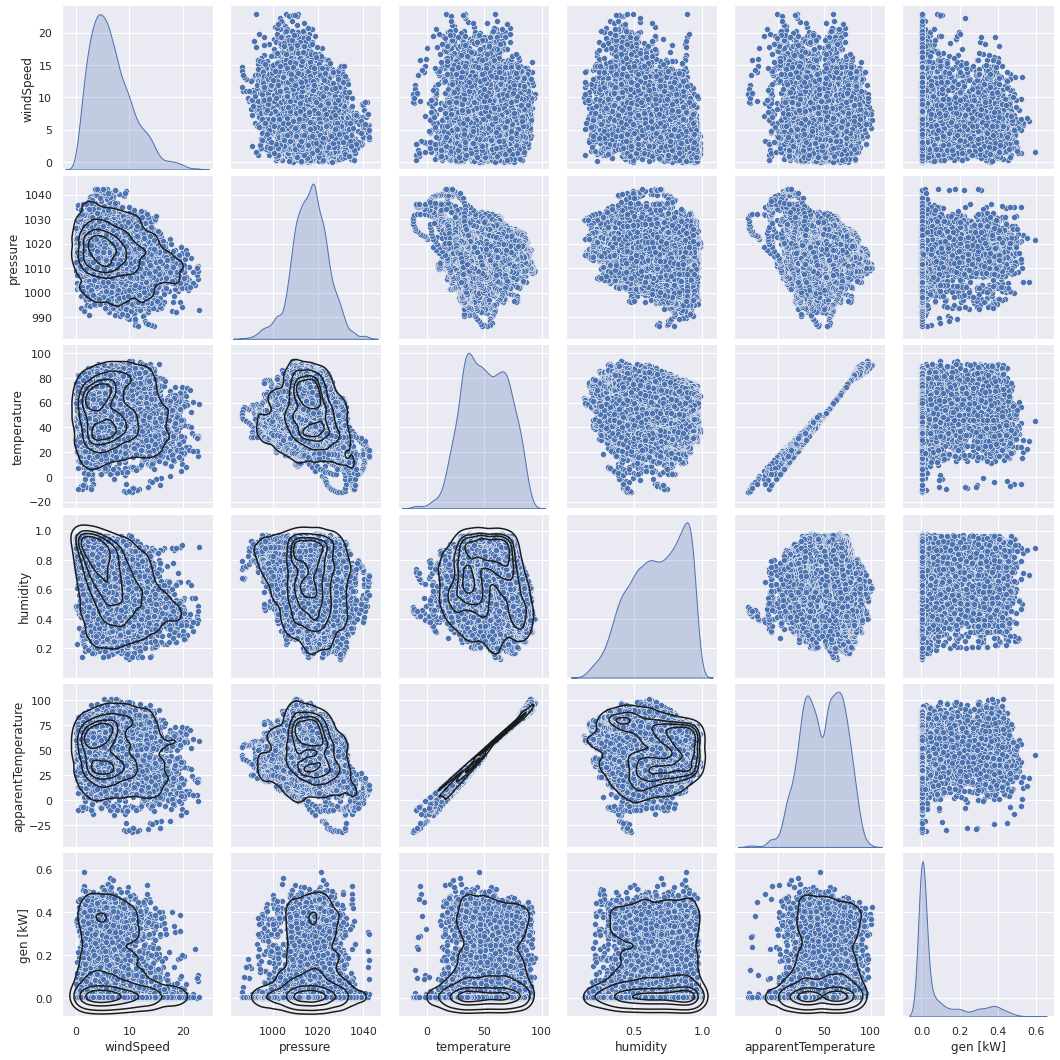

In [99]:
ax = sns.pairplot(smart_home[subsample_target], diag_kind='kde')
ax.map_lower(sns.kdeplot, levels=5, color='.1')

plt.show()

### Step 2
You need to make an estimation of multivariate mathematical expectation and
variance.


In [100]:
smart_home_subsample[subsample_target].mean()

windSpeed                 6.647687
pressure               1016.299005
temperature              50.747782
humidity                  0.663840
apparentTemperature      48.269132
gen [kW]                  0.076255
dtype: float64

In [101]:
smart_home_subsample[subsample_target].var()

windSpeed               15.790562
pressure                62.385000
temperature            365.567771
humidity                 0.037740
apparentTemperature    485.472716
gen [kW]                 0.016568
dtype: float64

### Step 3
You need to make a non-parametric estimation of conditional distributions,
mathematical expectations and variances.

In [66]:
smart_home.groupby(['summary'])['time'].nunique()

summary
Breezy                        27
Breezy and Mostly Cloudy       1
Breezy and Partly Cloudy      17
Clear                       6270
Drizzle                      173
Dry                            1
Flurries                      30
Flurries and Breezy            2
Foggy                         16
Heavy Snow                     3
Light Rain                   455
Light Snow                    73
Mostly Cloudy                 79
Overcast                     105
Partly Cloudy               1043
Rain                          83
Rain and Breezy                3
Snow                          18
Name: time, dtype: int64

In [102]:
smart_home_clear = smart_home[smart_home['summary'] == "Clear"][subsample_target]
smart_home_clear

,windSpeed,pressure,temperature,humidity,apparentTemperature,gen [kW]
0,9.18,1016.91,36.14,0.62,29.26,0.003483
2,8.20,1015.98,35.40,0.61,28.87,0.003517
3,5.47,1016.07,35.25,0.64,30.51,0.003433
4,7.08,1015.86,35.49,0.64,29.65,0.003500
5,6.45,1015.59,35.26,0.65,29.79,0.003450
...,...,...,...,...,...,...
8388,16.38,999.41,35.11,0.63,25.12,0.043717
8390,15.23,1002.10,33.97,0.60,24.03,0.234817
8391,14.85,1003.22,33.14,0.57,23.10,0.098700
8392,13.15,1004.37,31.68,0.58,21.89,0.002633


In [103]:
smart_home_clear.mean()

windSpeed                 6.434781
pressure               1017.576947
temperature              50.304710
humidity                  0.638951
apparentTemperature      47.755903
gen [kW]                  0.075984
dtype: float64

In [104]:
smart_home_clear.var()

windSpeed               14.236354
pressure                56.617847
temperature            383.265691
humidity                 0.037489
apparentTemperature    506.248081
gen [kW]                 0.016351
dtype: float64

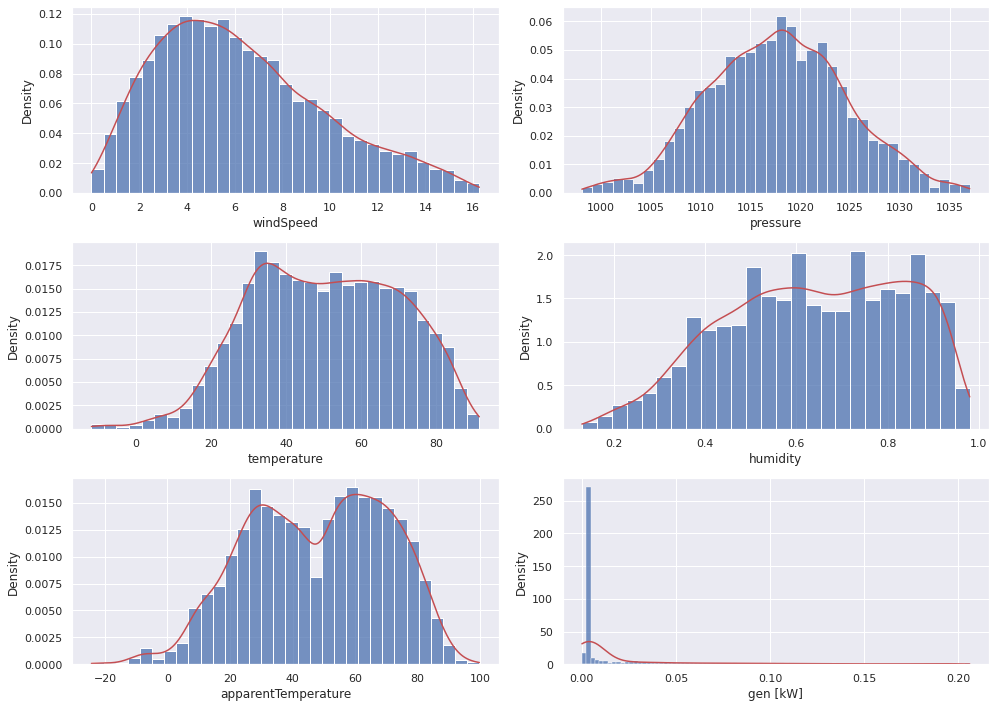

In [181]:
axs = {key: 0 for key in subsample_target}
fig, ((axs[subsample_target[0]], axs[subsample_target[1]]),
      (axs[subsample_target[2]], axs[subsample_target[3]]),
      (axs[subsample_target[4]], axs[subsample_target[5]])
      ) = plt.subplots(3, 2)
fig.set_size_inches(14, 10)

for var in subsample_target:
    estimation(smart_home_clear, var, axs[var])

fig.tight_layout()

In [107]:
smart_home_not_clear = smart_home[smart_home['summary'] != "Clear"][subsample_target]
smart_home_not_clear

,windSpeed,pressure,temperature,humidity,apparentTemperature,gen [kW]
1,8.29,1016.25,35.87,0.61,29.40,0.003450
7,5.77,1015.75,35.06,0.66,30.05,0.003417
13,9.45,1013.33,37.14,0.59,30.36,0.031017
17,7.91,1012.62,34.89,0.65,28.42,0.003433
18,7.58,1012.96,33.87,0.68,27.38,0.003450
...,...,...,...,...,...,...
8394,10.97,1012.77,36.63,0.72,29.03,0.004133
8395,11.77,1012.79,37.98,0.69,30.39,0.004133
8396,12.40,1012.28,36.73,0.79,28.57,0.004117
8397,7.82,1011.87,35.91,0.82,29.71,0.004117


In [110]:
smart_home_not_clear.mean()

windSpeed                 7.274702
pressure               1012.535406
temperature              52.052649
humidity                  0.737140
apparentTemperature      49.780615
gen [kW]                  0.077054
dtype: float64

In [111]:
smart_home_not_clear.var()

windSpeed               19.849724
pressure                60.420855
temperature            311.320319
humidity                 0.031299
apparentTemperature    421.435728
gen [kW]                 0.017214
dtype: float64

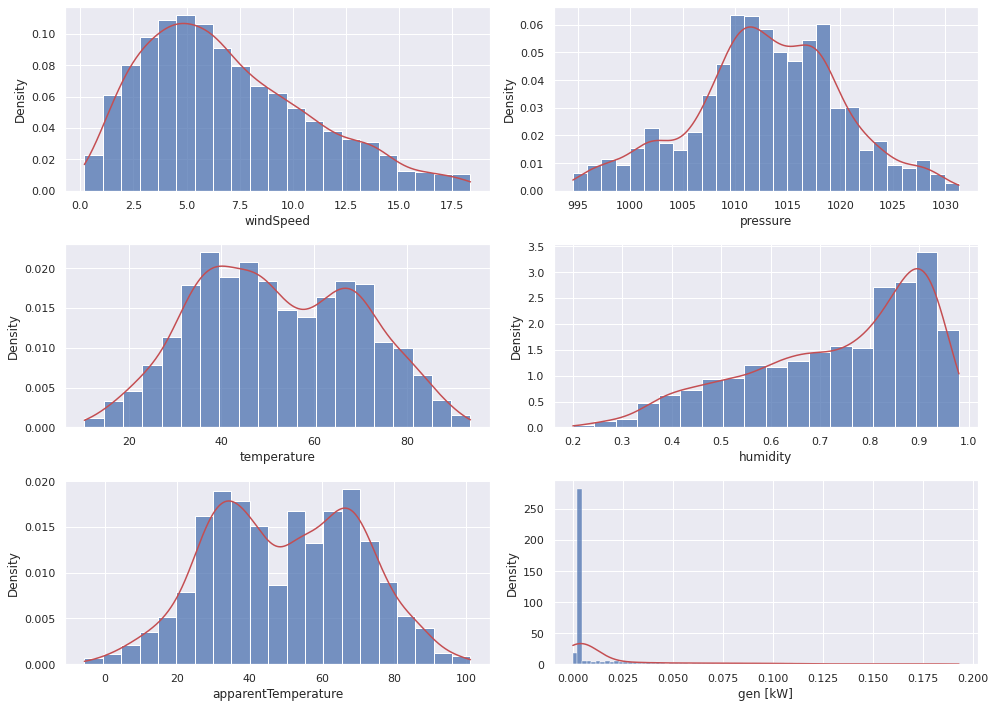

In [182]:
axs = {key: 0 for key in subsample_target}
fig, ((axs[subsample_target[0]], axs[subsample_target[1]]),
      (axs[subsample_target[2]], axs[subsample_target[3]]),
      (axs[subsample_target[4]], axs[subsample_target[5]])
      ) = plt.subplots(3, 2)
fig.set_size_inches(14, 10)

for var in subsample_target:
    estimation(smart_home_partly_cloudy, var, axs[var])

fig.tight_layout()

### Step 4
You need to make an estimation of **pair correlation coefficients**, **confidence intervals** for them and **significance levels**.

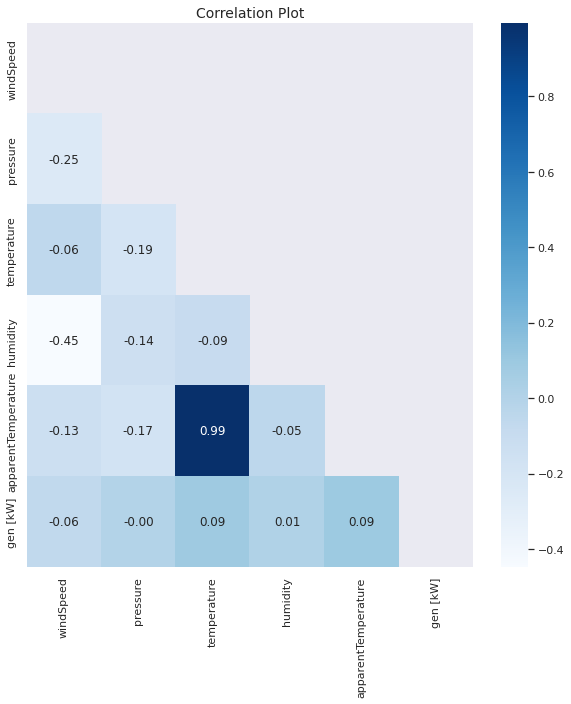

In [113]:
corr = smart_home[subsample_target].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr, mask = mask, annot=True, fmt= '.2f', ax = ax, cmap = 'Blues')

ax.set_title('Correlation Plot', fontsize=14)

plt.show()

In [125]:
corr = smart_home[subsample_target].corr()
print("Correlation coefficients")
corr

Correlation coefficients


,windSpeed,pressure,temperature,humidity,apparentTemperature,gen [kW]
windSpeed,1.000000,-0.245918,-0.057311,-0.447470,-0.128886,-0.060943
pressure,-0.245918,1.000000,-0.192493,-0.137191,-0.172560,-0.000367
temperature,-0.057311,-0.192493,1.000000,-0.089894,0.993231,0.091487
humidity,-0.447470,-0.137191,-0.089894,1.000000,-0.045907,0.010375
apparentTemperature,-0.128886,-0.172560,0.993231,-0.045907,1.000000,0.094406
gen [kW],-0.060943,-0.000367,0.091487,0.010375,0.094406,1.000000


In [124]:
def conf_int(x, y):
    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r) # matches Fisher transform
    # Corresponding standard deviation
    se = 1/np.sqrt(x.size - 3)
    alpha = 0.05
    z = stats.norm.ppf(1 - alpha / 2)
    lo_z, hi_z = r_z - z * se, r_z + z * se
    return round(lo_z, 3), round(hi_z, 3), round(p, 3)

level = corr.copy()
corr_coefficient = corr.copy()
pair_columns = list(combinations(subsample_target, 2))
for col1, col2 in pair_columns:
    lo_z, hi_z, p = conf_int(smart_home_subsample[col1], smart_home_subsample[col2])
    level 
    level[col1][col2] = p
    corr_coefficient[col1][col2] = str((lo_z, hi_z))

print("Confidence interval for the correlation coefficient")
display(level)
print("Significance level")
display(corr_coefficient)

Confidence interval for the correlation coefficient


,windSpeed,pressure,temperature,humidity,apparentTemperature,gen [kW]
windSpeed,1.0,-0.245918,-0.057311,-0.447470,-0.128886,-0.060943
pressure,0.0,1.000000,-0.192493,-0.137191,-0.172560,-0.000367
temperature,0.0,0.000000,1.000000,-0.089894,0.993231,0.091487
humidity,0.0,0.000000,0.000000,1.000000,-0.045907,0.010375
apparentTemperature,0.0,0.000000,0.000000,0.000000,1.000000,0.094406
gen [kW],0.0,0.973000,0.000000,0.342000,0.000000,1.000000


Significance level


,windSpeed,pressure,temperature,humidity,apparentTemperature,gen [kW]
windSpeed,1,-0.245918,-0.0573108,-0.44747,-0.128886,-0.060943
pressure,"(-0.272, -0.23)",1,-0.192493,-0.137191,-0.17256,-0.000367
temperature,"(-0.079, -0.036)","(-0.216, -0.174)",1,-0.0898942,0.993231,0.091487
humidity,"(-0.503, -0.46)","(-0.159, -0.117)","(-0.112, -0.069)",1,-0.0459074,0.010375
apparentTemperature,"(-0.151, -0.108)","(-0.196, -0.153)","(2.821, 2.864)","(-0.067, -0.025)",1,0.094406
gen [kW],"(-0.082, -0.04)","(-0.022, 0.021)","(0.07, 0.113)","(-0.011, 0.032)","(0.073, 0.116)",1.000000


### Step 5
Choose a task formulation for regression. Estimate multivariate correlation (target -predictors)

Problem statement: prediction of the generation energy based on conditions: temperature, humidity, apparentTemperature, pressure.

In [9]:
columns = ['pressure', 'temperature', 'humidity', 'apparentTemperature']

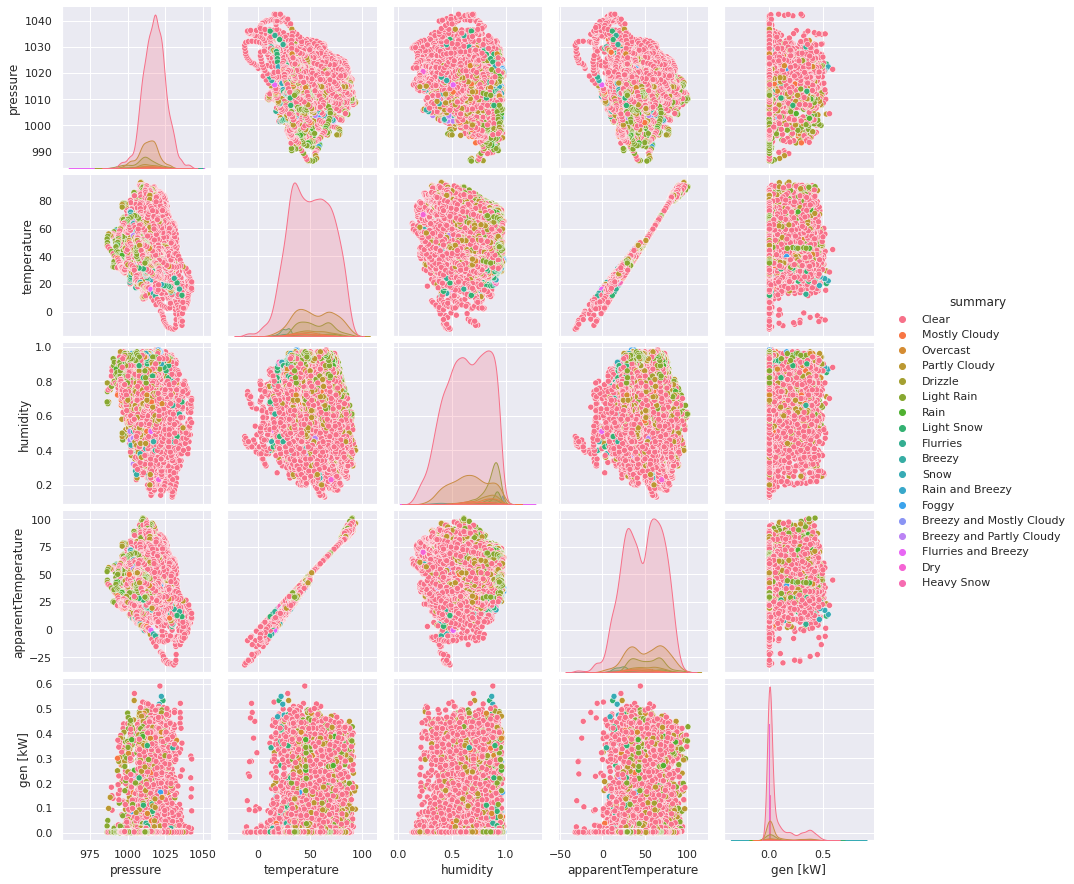

In [129]:
ax = sns.pairplot(smart_home[columns  + ['gen [kW]', 'summary']], diag_kind='kde', hue='summary')
plt.show()

### Step 6
Build regression model and make an analysis of multicollinearity and regularization (if needed).

In [10]:
X = smart_home[columns] 
y = smart_home[target] 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
ridge = Ridge(alpha=0.1, random_state=1)
ridge.fit(x_train, y_train)

mae = mean_absolute_error(y_test, ridge.predict(x_test))
mse = mean_squared_error(y_test, ridge.predict(x_test))
r2 = r2_score(y_test, ridge.predict(x_test))

print(f'Mean Absolute Error: {mae:.3f}')
print(f'Mean Squared Error: {mse:.3f}')
print(f'R2 Score: {r2:.3f}')

Mean Absolute Error: 0.096
Mean Squared Error: 0.016
R2 Score: 0.012


In [12]:
lars = Lars()
lars.fit(x_train, y_train)

mae = mean_absolute_error(y_test, lars.predict(x_test))
mse = mean_squared_error(y_test, lars.predict(x_test))
r2 = r2_score(y_test, lars.predict(x_test))

print(f'Mean Absolute Error: {mae:.3f}')
print(f'Mean Squared Error: {mse:.3f}')
print(f'R2 Score: {r2:.3f}')

Mean Absolute Error: 0.096
Mean Squared Error: 0.016
R2 Score: 0.012


In [13]:
lreg = LinearRegression()
lreg.fit(x_train, y_train)

mae = mean_absolute_error(y_test, lreg.predict(x_test))
mse = mean_squared_error(y_test, lreg.predict(x_test))
r2 = r2_score(y_test, lreg.predict(x_test))

print('Mean Absolute Error: {:.3f}'.format(mae))
print('Mean Squared Error: {:.3f}'.format(mse))
print('R2 Score: {:.3f}'.format(r2))

Mean Absolute Error: 0.096
Mean Squared Error: 0.016
R2 Score: 0.012


### Step 7
Analyze the quality of regression model (distribution of residuals, determination coefficient).

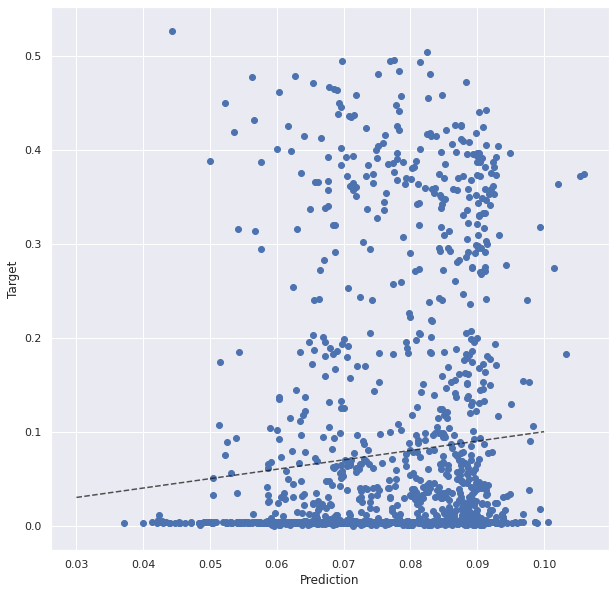

In [14]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

y_lreg = lreg.predict(x_test)
y_target = np.array(y_test)

ax.plot(y_lreg, y_target, ls="", marker="o", markersize=6)
ax.plot([0.01 * i for i in range(3,11)], [0.01 * i for i in range(3, 11)], color="k", ls="--", alpha=0.75)

plt.xlabel('Prediction')
plt.ylabel('Target')
plt.show()

In [15]:
residuals = y_target - y_lreg
print(residuals.mean())
print(residuals.var())

-0.004075055713490581
0.015901712585264956


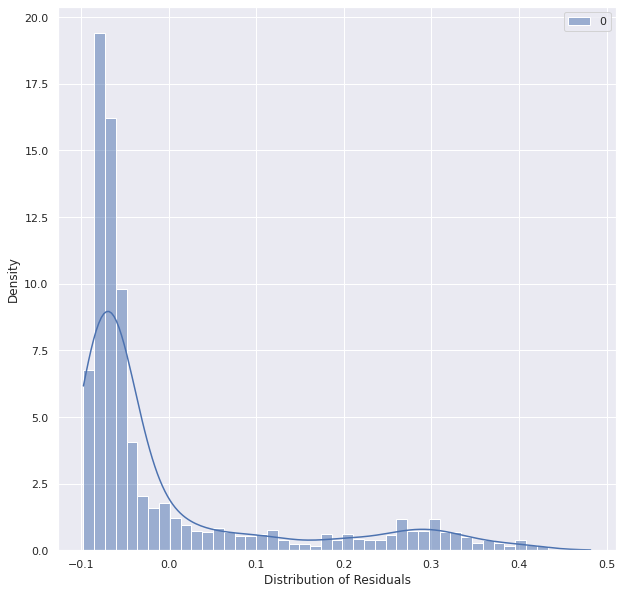

In [18]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot(residuals, ax=ax, kde=True, stat='density')
ax.set_xlabel('Distribution of Residuals')

plt.show()